https://wrds-www.wharton.upenn.edu/pages/wrds-research/applications/python-replications/historical-sp-500-index-constituents

https://wrds-www.wharton.upenn.edu/pages/get-data/center-research-security-prices-crsp/annual-update/stock-security-files/daily-stock-file/

https://wrds-www.wharton.upenn.edu/data-dictionary/contrib_global_factor/global_factor/

In [69]:
import pandas as pd
import wrds
from matplotlib import pyplot as plt

In [3]:
conn = wrds.Connection()

Enter your WRDS username [osx]:chunnijiang
Enter your password:········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: n
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [4]:
begdate = '2015-01-01'
enddate = '2022-12-30'

Get S&P 500 Constituent

In [5]:
sp500 = conn.raw_sql(f"""
                        select a.*, b.date
                        from crsp.msp500list as a,
                        crsp.msf as b
                        where a.permno=b.permno
                        and b.date >= a.start and b.date<= a.ending
                        and b.date>='{begdate}'
                        and b.date<='{enddate}'
                        order by date;
                        """, date_cols=['start', 'ending', 'date'])

In [6]:
mse = conn.raw_sql("""
                        select comnam, namedt, nameendt, 
                        permno, ticker
                        from crsp.msenames
                        """, date_cols=['namedt', 'nameendt'])

# if nameendt is missing then set to today date
mse['nameendt']=mse['nameendt'].fillna(pd.to_datetime('today'))

In [7]:
# Merge with SP500 data
sp500_full = pd.merge(sp500, mse, how = 'left', on = 'permno')

# Impose the date range restrictions
sp500_full = sp500_full.loc[(sp500_full.date>=sp500_full.namedt) \
                            & (sp500_full.date<=sp500_full.nameendt)]

In [8]:
sp500 = sp500_full[['permno', 'comnam', 'ticker']].drop_duplicates()
sp500

,permno,comnam,ticker
3,10104.0,ORACLE CORP,ORCL
5,10107.0,MICROSOFT CORP,MSFT
10,10138.0,T ROWE PRICE GROUP INC,TROW
25,10145.0,HONEYWELL INTERNATIONAL INC,HON
35,10147.0,E M C CORP MA,EMC
...,...,...,...
334048,86288.0,COSTAR GROUP INC,CSGP
337408,12476.0,TARGA RESOURCES CORP,TRGP
338896,75607.0,GEN DIGITAL INC,GEN
339302,82276.0,ARCH CAPITAL GROUP LTD NEW,ACGL


Read Price Volume data

In [9]:
permno_list = sp500['permno'].astype('int').to_list()
formatted_permnos = ",".join(["'{}'".format(permno) for permno in permno_list])

In [10]:
query = f"""
SELECT 
    permno, date, prc, vol, openprc, askhi, bidlo, ret, shrout
FROM 
    crsp_a_stock.dsf 
WHERE 
    permno IN ({formatted_permnos}) AND date BETWEEN '{begdate}' AND '{enddate}'
"""

price_vol = conn.raw_sql(query)

In [11]:
price_vol['date'] = pd.to_datetime(price_vol['date'])
price_vol['yyyy-mm'] = price_vol['date'].dt.strftime('%Y-%m')
price_vol

,permno,date,prc,vol,openprc,askhi,bidlo,ret,shrout,yyyy-mm
0,10104.0,2015-01-02,44.330002,15070165.0,45.020000,45.189800,43.970001,-0.014232,4391367.0,2015-01
1,10104.0,2015-01-05,43.590000,18375801.0,44.160000,44.250000,43.580002,-0.013986,4391367.0,2015-01
2,10104.0,2015-01-06,43.139999,19229461.0,44.060001,44.180000,42.990002,-0.010323,4391367.0,2015-01
3,10104.0,2015-01-07,43.150002,13502164.0,43.330002,43.520000,43.009998,0.000232,4391367.0,2015-01
4,10104.0,2015-01-08,43.410000,17516877.0,43.630001,43.939999,43.380001,0.006025,4391367.0,2015-01
...,...,...,...,...,...,...,...,...,...,...
221715,93436.0,2022-12-23,123.150002,166917212.0,126.370003,128.617294,121.019997,-0.017551,3157752.0,2022-12
221716,93436.0,2022-12-27,109.099998,208446557.0,117.495003,119.669998,108.760002,-0.114089,3157752.0,2022-12
221717,93436.0,2022-12-28,112.709999,220818648.0,110.349998,116.269997,108.239998,0.033089,3157752.0,2022-12
221718,93436.0,2022-12-29,121.820000,221592714.0,120.385002,123.570000,117.495003,0.080827,3157752.0,2022-12


# GICS
Read GICS data

In [13]:
query = f"""
SELECT 
    DISTINCT permno, gics, date
FROM 
    contrib_global_factor.global_factor
WHERE
    permno IN ({formatted_permnos}) AND date BETWEEN '{begdate}' AND '{enddate}'
"""

gics = conn.raw_sql(query)

In [14]:
gics['date'] = pd.to_datetime(gics['date'])
gics['yyyy-mm'] = gics['date'].dt.strftime('%Y-%m')
gics.drop(columns='date', inplace=True)
gics

,permno,gics,yyyy-mm
0,87717.0,20301010.0,2019-12
1,19502.0,30101010.0,2020-06
2,44329.0,35101010.0,2021-07
3,60442.0,40101015.0,2018-09
4,24328.0,10102020.0,2015-07
...,...,...,...
58326,92157.0,45203020.0,2018-12
58327,58246.0,40203010.0,2021-07
58328,10516.0,30202010.0,2015-10
58329,89641.0,45202030.0,2015-12


Merge price_vol and GICS information

In [15]:
price_vol_gics = pd.merge(price_vol, gics, how='left', on=['permno', 'yyyy-mm'])
price_vol_gics = pd.merge(price_vol_gics, sp500, how='left', on=['permno'])
price_vol_gics

,permno,date,prc,vol,openprc,askhi,bidlo,ret,shrout,yyyy-mm,gics,comnam,ticker
0,10104.0,2015-01-02,44.330002,15070165.0,45.020000,45.189800,43.970001,-0.014232,4391367.0,2015-01,45103020.0,ORACLE CORP,ORCL
1,10104.0,2015-01-05,43.590000,18375801.0,44.160000,44.250000,43.580002,-0.013986,4391367.0,2015-01,45103020.0,ORACLE CORP,ORCL
2,10104.0,2015-01-06,43.139999,19229461.0,44.060001,44.180000,42.990002,-0.010323,4391367.0,2015-01,45103020.0,ORACLE CORP,ORCL
3,10104.0,2015-01-07,43.150002,13502164.0,43.330002,43.520000,43.009998,0.000232,4391367.0,2015-01,45103020.0,ORACLE CORP,ORCL
4,10104.0,2015-01-08,43.410000,17516877.0,43.630001,43.939999,43.380001,0.006025,4391367.0,2015-01,45103020.0,ORACLE CORP,ORCL
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1397279,93436.0,2022-12-23,123.150002,166917212.0,126.370003,128.617294,121.019997,-0.017551,3157752.0,2022-12,25102010.0,TESLA INC,TSLA
1397280,93436.0,2022-12-27,109.099998,208446557.0,117.495003,119.669998,108.760002,-0.114089,3157752.0,2022-12,25102010.0,TESLA INC,TSLA
1397281,93436.0,2022-12-28,112.709999,220818648.0,110.349998,116.269997,108.239998,0.033089,3157752.0,2022-12,25102010.0,TESLA INC,TSLA
1397282,93436.0,2022-12-29,121.820000,221592714.0,120.385002,123.570000,117.495003,0.080827,3157752.0,2022-12,25102010.0,TESLA INC,TSLA


Save to parquet

In [16]:
price_vol_gics.to_parquet('data/price_vol_gics.parquet.gzip', compression='gzip')

In [17]:
conn.close()

GICS map

Note that according to GICS 2023 standard, some names have changed.

In [44]:
sector_map = {
    10: 'Energy',
    15: 'Materials',
    20: 'Industrials',
    25: 'Consumer Discretionary',
    30: 'Consumer Staples',
    35: 'Health Care',
    40: 'Financials',
    45: 'Information Technology',
    50: 'Communication Services',
    55: 'Utilities',
    60: 'Real Estate'
}

In [45]:
industry_group_map = {
    1010: 'Energy',
    1510: 'Materials',
    2010: 'Capital Goods',
    2020: 'Commercial & Professional Services',
    2030: 'Transportation',
    2510: 'Automobiles & Components',
    2520: 'Consumer Durables & Apparel',
    2530: 'Consumer Services',
    2550: 'Consumer Discretionary Distribution & Retail',
    3010: 'Consumer Staples Distribution & Retail',
    3020: 'Food, Beverage & Tobacco',
    3030: 'Household & Personal Products',
    3510: 'Health Care Equipment & Services',
    3520: 'Pharmaceuticals, Biotechnology & Life Sciences',
    4010: 'Banks',
    4020: 'Financial Services',
    4030: 'Insurance',
    4510: 'Software & Services',
    4520: 'Technology Hardware & Equipment',
    4530: 'Semiconductors & Semiconductor Equipment',
    5010: 'Telecommunication Services',
    5020: 'Media & Entertainment',
    5510: 'Utilities',
    6010: 'Equity Real Estate Investment Trusts (REITs)',
    6020: 'Real Estate Management & Development'
}


# Filter SP500 in holdings & merge industry gics

holdings

In [93]:
import pyarrow.parquet as pq

# Specify the path to your parquet.gzip file
parquet_file_path = 'data/holdings.parquet.gzip'

# Read the Parquet file using pyarrow
holdings = pq.read_table(parquet_file_path)

# Convert the table to a Pandas DataFrame if needed
holdings = holdings.to_pandas()

holdings.head()

,rdate,mgrno,first_report,last_report,shares,permno,shares_adj,phrdate,pshares_adj,trade,qtrgap,lpermno,npermno,modtrade,buysale
3890200,2021-06-30,110.0,False,False,3000.0,10104.0,3000.0,2021-03-31,3000.0,0.0,1,NaN,10104.0,3000.0,1.0
3888122,2021-09-30,110.0,False,False,3000.0,10104.0,3000.0,2021-06-30,3000.0,0.0,1,10104.0,10104.0,0.0,0.0
3886028,2021-12-31,110.0,False,False,3000.0,10104.0,3000.0,2021-09-30,3000.0,0.0,1,10104.0,10104.0,0.0,0.0
3883846,2022-03-31,110.0,False,False,3000.0,10104.0,3000.0,2021-12-31,3000.0,0.0,1,10104.0,10104.0,0.0,0.0
3881706,2022-06-30,110.0,False,False,3000.0,10104.0,3000.0,2022-03-31,3000.0,0.0,1,10104.0,10107.0,0.0,0.0


In [94]:
holdings = holdings.rename(columns = {'rdate':'date'})
holdings['year'] = holdings['date'].dt.year
holdings = holdings[holdings['permno'].isin(sp500['permno'])]

In [95]:
holdings = pd.merge(holdings, price_vol_gics, on = ['date', 'permno'], how = 'left')
holdings['gics'] = holdings['gics'].fillna(0)

holdings.head()

,date,mgrno,first_report,last_report,shares,permno,shares_adj,phrdate,pshares_adj,trade,...,vol,openprc,askhi,bidlo,ret,shrout,yyyy-mm,gics,comnam,ticker
0,2021-06-30,110.0,False,False,3000.0,10104.0,3000.0,2021-03-31,3000.0,0.0,...,7899840.0,77.589996,78.209999,77.580002,-0.003329,2792000.0,2021-06,45103020.0,ORACLE CORP,ORCL
1,2021-09-30,110.0,False,False,3000.0,10104.0,3000.0,2021-06-30,3000.0,0.0,...,15651919.0,91.250000,91.580002,87.120003,-0.045151,2733686.0,2021-09,45103020.0,ORACLE CORP,ORCL
2,2021-12-31,110.0,False,False,3000.0,10104.0,3000.0,2021-09-30,3000.0,0.0,...,5908158.0,88.050003,88.099998,87.180000,-0.009090,2670447.0,2021-12,45103020.0,ORACLE CORP,ORCL
3,2022-03-31,110.0,False,False,3000.0,10104.0,3000.0,2021-12-31,3000.0,0.0,...,9433347.0,83.110001,83.910004,82.589996,-0.007558,2668157.0,2022-03,45103020.0,ORACLE CORP,ORCL
4,2022-06-30,110.0,False,False,3000.0,10104.0,3000.0,2022-03-31,3000.0,0.0,...,9888767.0,68.209999,70.250000,68.209999,0.009536,2664926.0,2022-06,45103020.0,ORACLE CORP,ORCL


In [96]:
holdings['gics1'] = holdings['gics'].apply(lambda x:sector_map[int(x//1e6)] if int(x//1e6) in sector_map.keys() else 'Unknown')
holdings['gics2'] = holdings['gics'].apply(lambda x:industry_group_map[int(x//1e4)]if int(x//1e4) in industry_group_map.keys() else 'Unknown')

holdings.head()

,date,mgrno,first_report,last_report,shares,permno,shares_adj,phrdate,pshares_adj,trade,...,askhi,bidlo,ret,shrout,yyyy-mm,gics,comnam,ticker,gics1,gics2
0,2021-06-30,110.0,False,False,3000.0,10104.0,3000.0,2021-03-31,3000.0,0.0,...,78.209999,77.580002,-0.003329,2792000.0,2021-06,45103020.0,ORACLE CORP,ORCL,Information Technology,Software & Services
1,2021-09-30,110.0,False,False,3000.0,10104.0,3000.0,2021-06-30,3000.0,0.0,...,91.580002,87.120003,-0.045151,2733686.0,2021-09,45103020.0,ORACLE CORP,ORCL,Information Technology,Software & Services
2,2021-12-31,110.0,False,False,3000.0,10104.0,3000.0,2021-09-30,3000.0,0.0,...,88.099998,87.180000,-0.009090,2670447.0,2021-12,45103020.0,ORACLE CORP,ORCL,Information Technology,Software & Services
3,2022-03-31,110.0,False,False,3000.0,10104.0,3000.0,2021-12-31,3000.0,0.0,...,83.910004,82.589996,-0.007558,2668157.0,2022-03,45103020.0,ORACLE CORP,ORCL,Information Technology,Software & Services
4,2022-06-30,110.0,False,False,3000.0,10104.0,3000.0,2022-03-31,3000.0,0.0,...,70.250000,68.209999,0.009536,2664926.0,2022-06,45103020.0,ORACLE CORP,ORCL,Information Technology,Software & Services


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

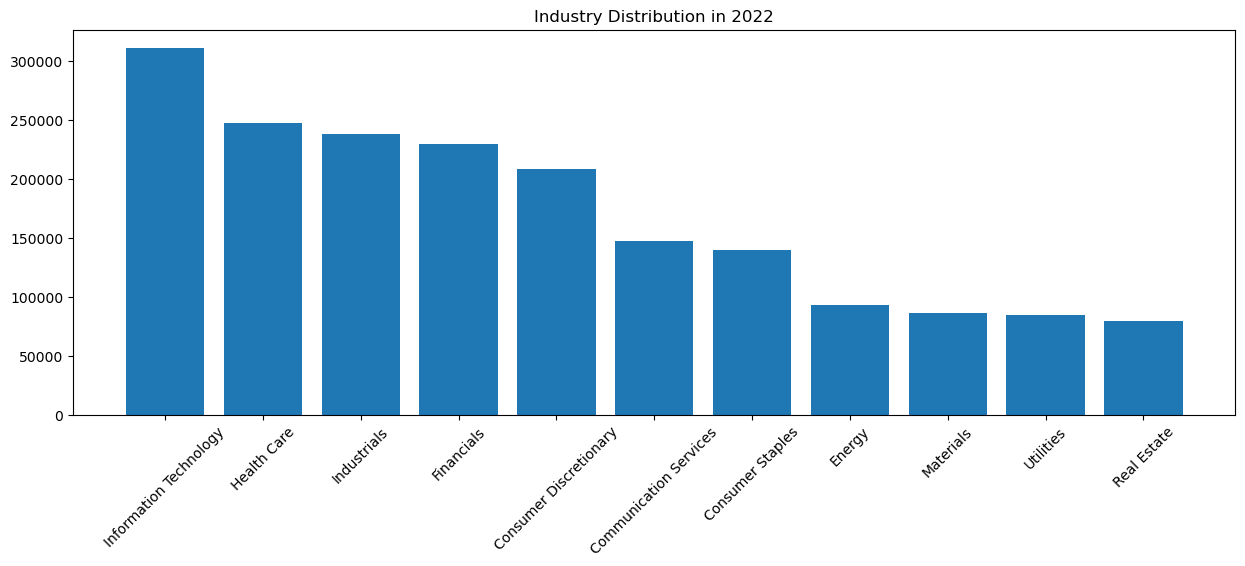

In [97]:
recent_holdings = holdings[holdings['year']==2022]
industry = recent_holdings['gics1'].value_counts()

plt.figure(figsize = (15,5))
plt.bar(industry.index, industry)
plt.title('Industry Distribution in 2022')
plt.xticks(rotation = 45)

In [98]:
holdings.to_parquet('data/holdings_sp500.parquet.gzip', compression='gzip')